# Traffic Signs Classification using ResNet50
(Performance on Google Colaboratory is best using a GPU runtime)

In [5]:
import numpy as np
import pandas as pd
import os

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style('whitegrid')
%matplotlib inline
from tensorflow.keras.utils import plot_model

# Splitting data
from sklearn.model_selection import train_test_split

# Metrics 
from sklearn.metrics import confusion_matrix, classification_report

# Deep Learning
import tensorflow as tf
print('TensoFlow Version: ', tf.__version__)
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D, BatchNormalization, Dropout
from tensorflow.keras.applications.resnet import ResNet50

from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, CSVLogger

TensoFlow Version:  2.5.0


In [6]:
path = 'drive/MyDrive/Traffic Signs Classification - data/'
lab = pd.read_csv(path + 'labels.csv')

## Data overview

In [7]:
# Count PLot of the samples/observations w.r.t the classes
d = dict()
class_labels = dict()
for dirs in os.listdir(path + 'myData/myData'):
    count = len(os.listdir(path + 'myData/myData/' + dirs))
    d[dirs+' => '+lab[lab.ClassId == int(dirs)].values[0][1]] = count
    class_labels[int(dirs)] = lab[lab.ClassId == int(dirs)].values[0][1]

# plt.figure(figsize = (20, 50))
# sns.barplot(y = list(d.keys()), x = list(d.values()), palette = 'Set3')
# plt.ylabel('Label')
# plt.xlabel('Count of Samples/Observations');

In [8]:
# !rm -rf 'drive/MyDrive/Traffic Signs Classification - data/myData'

In [9]:
# !unzip 'drive/MyDrive/Traffic Signs Classification - data/archive.zip' -d 'drive/MyDrive/Traffic Signs Classification - data/myData'

In [10]:
d = dict()
class_labels = dict()
for dirs in os.listdir(path + 'myData/myData'):
    count = len(os.listdir(path + 'myData/myData/'+dirs))
    d[dirs+' => '+lab[lab.ClassId == int(dirs)].values[0][1]] = count
    class_labels[int(dirs)] = lab[lab.ClassId == int(dirs)].values[0][1]

In [11]:
# input image dimensions
img_rows, img_cols = 32, 32
# The images are RGB.
img_channels = 3
nb_classes = len(class_labels.keys())

datagen = ImageDataGenerator()
data = datagen.flow_from_directory('drive/MyDrive/Traffic Signs Classification - data/myData/myData',
                                    target_size=(32, 32),
                                    batch_size=73139,
                                    class_mode='categorical',
                                    shuffle=True )

Found 73139 images belonging to 43 classes.


In [12]:
X, y = data.next()

In [13]:
# Labels are one hot encoded
print(f"Data Shape   :{X.shape}\nLabels shape :{y.shape}")

Data Shape   :(73139, 32, 32, 3)
Labels shape :(73139, 43)


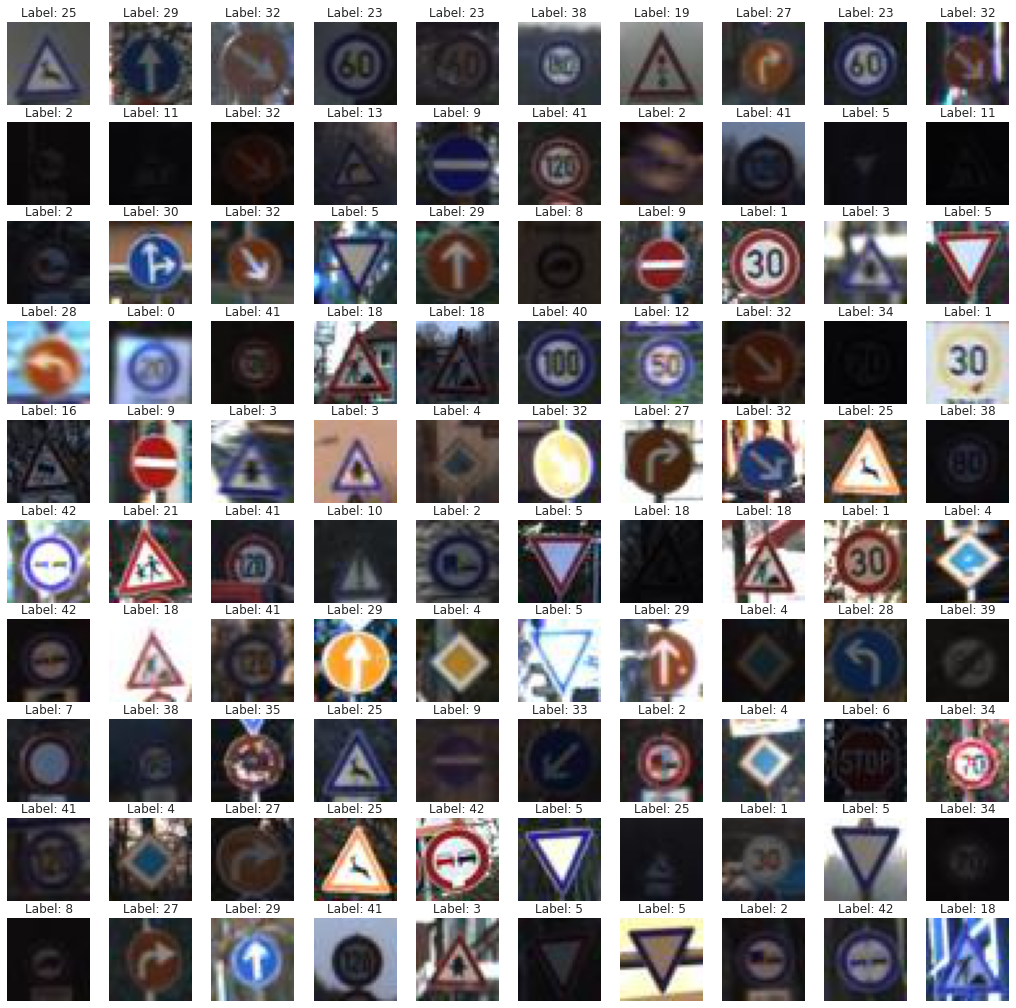

In [14]:
fig, axes = plt.subplots(10,10, figsize=(18,18))
for i,ax in enumerate(axes.flat):
    r = np.random.randint(X.shape[0])
    ax.imshow(X[r].astype('uint8'))
    ax.grid(False)
    ax.axis('off')
    ax.set_title('Label: '+str(np.argmax(y[r])))

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=11)

In [16]:
print("Train Shape: {}\nTest Shape : {}".format(X_train.shape, X_test.shape))

Train Shape: (58511, 32, 32, 3)
Test Shape : (14628, 32, 32, 3)


## Setting up ResNet50 model

In [17]:
resnet = ResNet50(weights= None, include_top=False, input_shape= (img_rows,img_cols,img_channels))

In [18]:
x = resnet.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
predictions = Dense(nb_classes, activation= 'softmax')(x)
model = Model(inputs = resnet.input, outputs = predictions)

In [19]:
# model.summary()

In [20]:
# plot_model(model, show_layer_names=True, show_shapes =True, to_file='model.png', dpi=350)

## Compiling

In [21]:
from keras.metrics import Precision, Recall

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', Precision(), Recall()])

## Creating callbacks

In [22]:
model_check = ModelCheckpoint('best_model.h5', monitor='val_accuracy', verbose=0, save_best_only=True, mode='max')
early = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=5, verbose=0, mode='max', restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001)
csv_logger = CSVLogger('train_log.csv', separator=',')

## Fitting model

In [23]:
n_epochs = 50
b_size = 32

history =  model.fit(X_train, y_train,  batch_size = b_size, epochs = n_epochs, verbose = 1, 
              validation_data = (X_test, y_test), callbacks = [model_check, early, reduce_lr, csv_logger])

Epoch 1/50
1829/1829 [==============================] - 123s 45ms/step - loss: 3.3849 - accuracy: 0.3447 - precision: 0.3565 - recall: 0.0727 - val_loss: 14.2341 - val_accuracy: 0.4566 - val_precision: 0.6404 - val_recall: 0.2348


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/50
1829/1829 [==============================] - 86s 47ms/step - loss: 1.8828 - accuracy: 0.6386 - precision: 0.6785 - recall: 0.3195 - val_loss: 235.9687 - val_accuracy: 0.2082 - val_precision: 0.6891 - val_recall: 0.3673
Epoch 3/50
1829/1829 [==============================] - 83s 45ms/step - loss: 1.5526 - accuracy: 0.6930 - precision: 0.6965 - recall: 0.3979 - val_loss: 1.1934 - val_accuracy: 0.7747 - val_precision: 0.7235 - val_recall: 0.4394
Epoch 4/50
1829/1829 [==============================] - 82s 45ms/step - loss: 0.8504 - accuracy: 0.7999 - precision: 0.7458 - recall: 0.4799 - val_loss: 0.4133 - val_accuracy: 0.8689 - val_precision: 0.7697 - val_recall: 0.5216
Epoch 5/50
1829/1829 [==============================] - 82s 45ms/step - loss: 0.4183 - accuracy: 0.8865 - precision: 0.7899 - recall: 0.5576 - val_loss: 0.1112 - val_accuracy: 0.9662 - val_precision: 0.8097 - val_recall: 0.5927
Epoch 6/50
1829/1829 [==============================] - 87s 47ms/step - loss: 0.3907 -

We had an early stopping in epoch 15

In [26]:
# Saving the model
model.save(path + 'TSC_model_1.h5')

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [28]:
# loss, acc = model.evaluate(X_test, y_test)
# print('Accuracy: ', acc, '\nLoss    : ', loss)

eval = model.evaluate(X_test, y_test)

print(model.metrics_names)
print(eval)

458/458 [==============================] - 7s 15ms/step - loss: 0.0170 - accuracy: 0.9962 - precision: 0.9650 - recall: 0.9240
['loss', 'accuracy', 'precision', 'recall']
[0.017030321061611176, 0.9961717128753662, 0.9650381207466125, 0.9240068793296814]


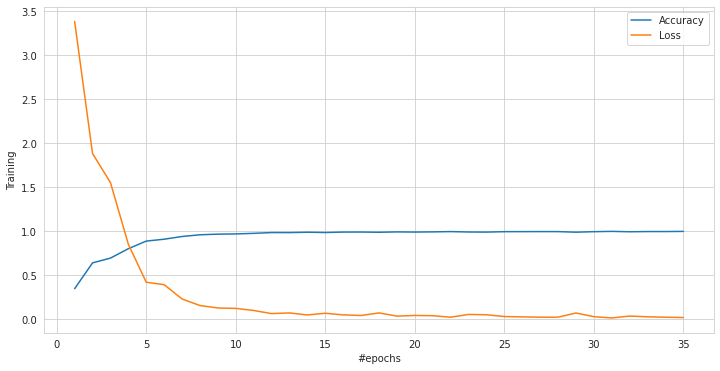

In [29]:
q = len(list(history.history['loss']))
plt.figure(figsize=(12, 6))
sns.lineplot(x = range(1, 1+q), y = history.history['accuracy'], label = 'Accuracy')
sns.lineplot(x = range(1, 1+q), y = history.history['loss'], label = 'Loss')
plt.xlabel('#epochs')
plt.ylabel('Training')
plt.legend();

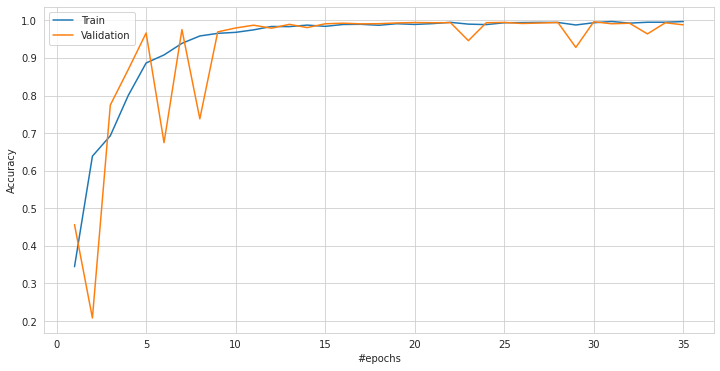

In [30]:
plt.figure(figsize=(12, 6))
sns.lineplot(x = range(1, 1+q), y = history.history['accuracy'], label = 'Train')
sns.lineplot(x = range(1, 1+q), y = history.history['val_accuracy'], label = 'Validation')
plt.xlabel('#epochs')
plt.ylabel('Accuracy')
plt.legend();

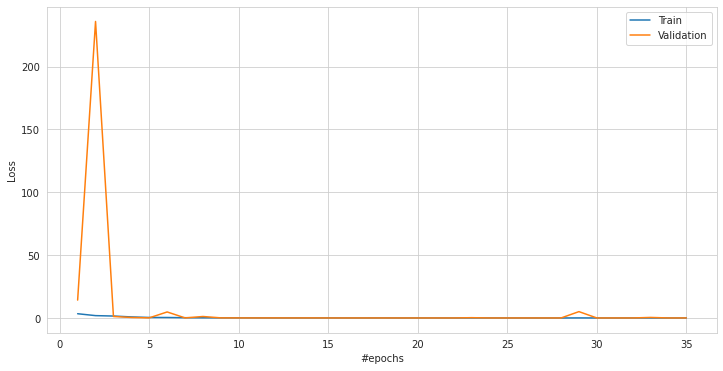

In [31]:
plt.figure(figsize=(12, 6))
sns.lineplot(x = range(1, 1+q), y = history.history['loss'], label = 'Train')
sns.lineplot(x = range(1, 1+q), y = history.history['val_loss'], label = 'Validation')
plt.xlabel('#epochs')
plt.ylabel('Loss')
plt.legend();

## Predictions on unseen data

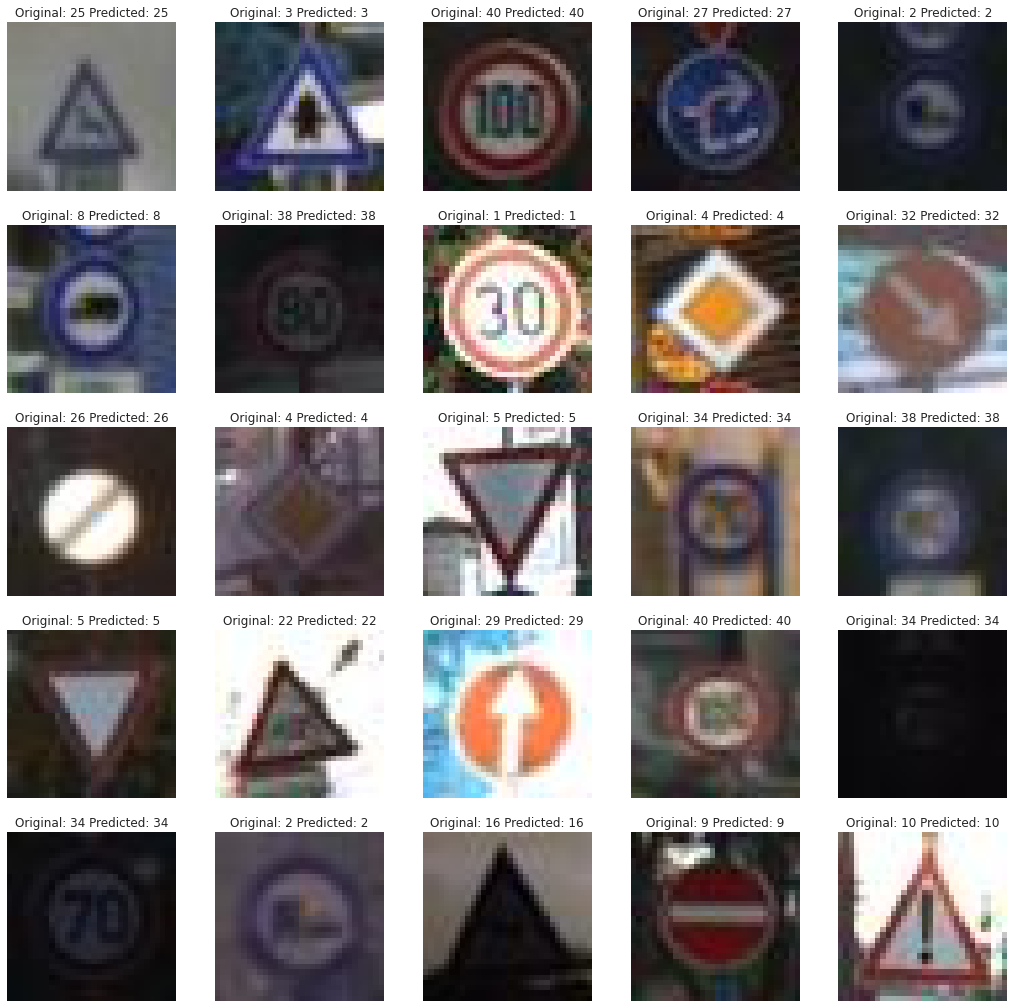

In [32]:
fig, axes = plt.subplots(5,5, figsize=(18,18))
for i,ax in enumerate(axes.flat):
    r = np.random.randint(X_test.shape[0])
    ax.imshow(X_test[r].astype('uint8'))
    ax.grid(False)
    ax.axis('off')
    ax.set_title('Original: {} Predicted: {}'.format(np.argmax(y_test[r]), np.argmax(model.predict(X_test[r].reshape(1, 32, 32, 3)))))
